In [ ]:
# https://www.kaggle.com/new-york-state/nys-spill-incidents

In [61]:
import numpy as np
import pandas as pd
import folium
import geopy
import time
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from folium import FeatureGroup, LayerControl, Map, Marker
from geopy.geocoders import Nominatim
from pandas.plotting import register_matplotlib_converters

pd.plotting.register_matplotlib_converters()

nom=Nominatim(user_agent="my-application")
p = sns.cubehelix_palette(15)
p2 = sns.cubehelix_palette(10)
p3 = sns.cubehelix_palette(24)
p4 = sns.cubehelix_palette(5)

%matplotlib inline

In [ ]:
# Take in raw data and examine it...

In [2]:
dataFile = 'spill-incidents.csv' # ../input/crime.csvspill-incidents.csv

In [3]:
NYSspillsRAW_df = pd.read_csv(dataFile)

In [4]:
NYSspillsRAW_df.head()

,Spill Number,Program Facility Name,Street 1,Street 2,Locality,County,ZIP Code,SWIS Code,DEC Region,Spill Date,Received Date,Contributing Factor,Waterbody,Source,Close Date,Material Name,Material Family,Quantity,Units,Recovered
0,107132,MH 864,RT 119/MILLWOOD RD,NaN,ELMSFORD,Westchester,NaN,6000,3,2001-10-10T00:00:00.000,2001-10-10T00:00:00.000,Unknown,NaN,Unknown,2001-10-15T00:00:00.000,unknown material,Other,10.0,Gallons,0.0
1,405586,BOWRY BAY,WATER POLL CONTROL,NaN,QUEENS,Queens,NaN,4101,2,2004-08-21T00:00:00.000,2004-08-21T00:00:00.000,Other,EAST RIVER,Unknown,2004-09-17T00:00:00.000,raw sewage,Other,0.0,Pounds,0.0
2,405586,BOWRY BAY,WATER POLL CONTROL,NaN,QUEENS,Queens,NaN,4101,2,2004-08-21T00:00:00.000,2004-08-21T00:00:00.000,Other,EAST RIVER,Unknown,2004-09-17T00:00:00.000,raw sewage,Other,0.0,NaN,0.0
3,204667,POLE 16091,GRACE AVE/BURKE AVE,NaN,BRONX,Bronx,NaN,301,2,2002-08-02T00:00:00.000,2002-08-02T00:00:00.000,Equipment Failure,NaN,Commercial/Industrial,2002-10-28T00:00:00.000,transformer oil,Petroleum,1.0,Gallons,0.0
4,210559,POLE ON,FERDALE LOMIS RD / RT 52,NaN,LIBERTY,Sullivan,NaN,5336,3,2003-01-20T00:00:00.000,2003-01-20T00:00:00.000,Traffic Accident,NaN,Commercial/Industrial,2003-01-22T00:00:00.000,transformer oil,Petroleum,6.0,Gallons,6.0


In [7]:
NYSspillsRAW_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 496993 entries, 0 to 496992
Data columns (total 20 columns):
Spill Number             496993 non-null int64
Program Facility Name    496986 non-null object
Street 1                 496954 non-null object
Street 2                 50277 non-null object
Locality                 495919 non-null object
County                   496993 non-null object
ZIP Code                 44785 non-null object
SWIS Code                496993 non-null int64
DEC Region               496993 non-null int64
Spill Date               496841 non-null object
Received Date            496993 non-null object
Contributing Factor      496993 non-null object
Waterbody                43863 non-null object
Source                   496993 non-null object
Close Date               485432 non-null object
Material Name            496993 non-null object
Material Family          496993 non-null object
Quantity                 496993 non-null float64
Units                    41484

In [8]:
NYSspillsRAW_df.describe()

,Spill Number,SWIS Code,DEC Region,Quantity,Recovered
count,4.969930e+05,496993.000000,496993.000000,4.969930e+05,4.969930e+05
mean,4.400582e+06,3479.402157,4.001829,2.034930e+05,4.893163e+02
std,4.184657e+06,1717.390505,2.594388,1.418493e+08,2.230706e+05
min,1.000000e+00,100.000000,1.000000,0.000000e+00,0.000000e+00
25%,7.093480e+05,2401.000000,2.000000,0.000000e+00,0.000000e+00
50%,1.603368e+06,3400.000000,3.000000,0.000000e+00,0.000000e+00
75%,9.209148e+06,5200.000000,6.000000,5.000000e+00,0.000000e+00
max,9.975754e+06,9500.000000,9.000000,1.000000e+11,1.111111e+08


In [ ]:
# Clean up raw data - set date format, re-order into ascending date order, remove old codes

In [9]:
NYSspillsRAW_df['Spill Date'] = pd.to_datetime(NYSspillsRAW_df['Spill Date'])
NYSspillsRAW_df.index = pd.DatetimeIndex(NYSspillsRAW_df['Spill Date'])

In [16]:
NYSspillsRAW_df2 = NYSspillsRAW_df.sort_index().copy()

In [17]:
NYSspillsRAW_df2.head()

,Spill Number,Program Facility Name,Street 1,Street 2,Locality,County,ZIP Code,SWIS Code,DEC Region,Spill Date,Received Date,Contributing Factor,Waterbody,Source,Close Date,Material Name,Material Family,Quantity,Units,Recovered
Spill Date,,,,,,,,,,,,,,,,,,,,
1900-01-01,9108142,REPUBLIC STEEL DUMP HUDSON RIVER (WATER ST?),HUDSON RIVER NEAR WWTP (MAIN ST? WATER ST?),REPUBLIC STEEL DUMP NEAR RCSD TREATMENT,TROY,Rensselaer,NaN,4217,4,1900-01-01,1991-10-04T00:00:00.000,Other,GROUNDWATER HUDSON $,Commercial/Industrial,1991-11-05T00:00:00.000,coal tar pitch volatiles,Hazardous Material,0.0,Pounds,0.0
1900-12-29,9010299,695 9TH AVE/MANH,695 9TH AVENUE,NaN,MANHATTAN,New York,NaN,3101,2,1900-12-29,1990-12-22T00:00:00.000,Tank Overfill,NaN,Commercial/Industrial,1994-11-16T00:00:00.000,#2 fuel oil,Petroleum,2.0,Gallons,0.0
1909-11-12,909514,ROADSIDE DITCH,4510 EAST RAIL ROAD,NaN,STOCKTON,Chautauqua,NaN,768,9,1909-11-12,2009-11-25T00:00:00.000,Human Error,BEAR CREEK,Passenger Vehicle,2009-12-07T00:00:00.000,transmission fluid,Petroleum,2.0,Gallons,0.0
1911-11-11,7901602,UNKNOWN,TABERG RD - BLOOSVALE,NaN,ANNSVILLE (T),Oneida,NaN,3300,6,1911-11-11,1980-03-24T00:00:00.000,Unknown,GROUNDWATER,Unknown,1980-05-15T00:00:00.000,unknown petroleum,Petroleum,0.0,NaN,0.0
1911-11-11,8601732,Spill Number 8601732,,NaN,NaN,Monroe,NaN,2800,8,1911-11-11,1911-11-11T00:00:00.000,Unknown,NaN,Unknown,1993-05-12T00:00:00.000,unknown material,Other,0.0,NaN,0.0


In [18]:
len(NYSspillsRAW_df2)

496993

In [23]:
# https://stackoverflow.com/questions/18172851/deleting-dataframe-row-in-pandas-based-on-column-value
NYSspillsRAW_df3 = NYSspillsRAW_df2[NYSspillsRAW_df2['Source']!='Missing Code in Old Data - Must be fixed']

In [24]:
len(NYSspillsRAW_df3)

488581

In [ ]:
# narrow down, clean up the date range (early entries are sparse, some are blanks)

In [43]:
NYSspillsRAW_df4 = NYSspillsRAW_df3[['Street 1', 'Locality', 'County', 'Spill Date', 'Contributing Factor',
                                'Source', 'Material Name', 'Material Family', 'Quantity', 'Units']].dropna()

In [44]:
len(NYSspillsRAW_df4)

405789

In [46]:
NYSspillsRAW_df5 = NYSspillsRAW_df4[NYSspillsRAW_df4['Spill Date'] >= '1984-01-01' ]

In [47]:
NYSspillsRAW_df5.head()

,Street 1,Locality,County,Spill Date,Contributing Factor,Source,Material Name,Material Family,Quantity,Units
Spill Date,,,,,,,,,,
1984-01-01,TOWN WELL SUPPLY,CHESTERTOWN,Warren,1984-01-01,Unknown,Unknown,gasoline,Petroleum,0.0,Gallons
1984-01-01,RT. 40,GRANVILLE,Washington,1984-01-01,Unknown,Unknown,gasoline,Petroleum,0.0,Gallons
1984-01-01,RT. 40,GRANVILLE,Washington,1984-01-01,Unknown,Unknown,#2 fuel oil,Petroleum,0.0,Gallons
1984-01-02,22 MEADOWOOD DRIVE,PERINTON,Monroe,1984-01-02,Unknown,Unknown,#2 fuel oil,Petroleum,10.0,Gallons
1984-01-04,BLUE BARNES ROAD,BURNT HILLS,Saratoga,1984-01-04,Equipment Failure,Private Dwelling,#2 fuel oil,Petroleum,200.0,Gallons


In [ ]:
# Let's visualize some of the basic content

In [55]:
spillLocalities = NYSspillsRAW_df5['Locality'].value_counts()
top20SpillLocalities = spillLocalities[:20]

In [56]:
matCat_freq = NYSspillsRAW_df5['Material Family'].value_counts()

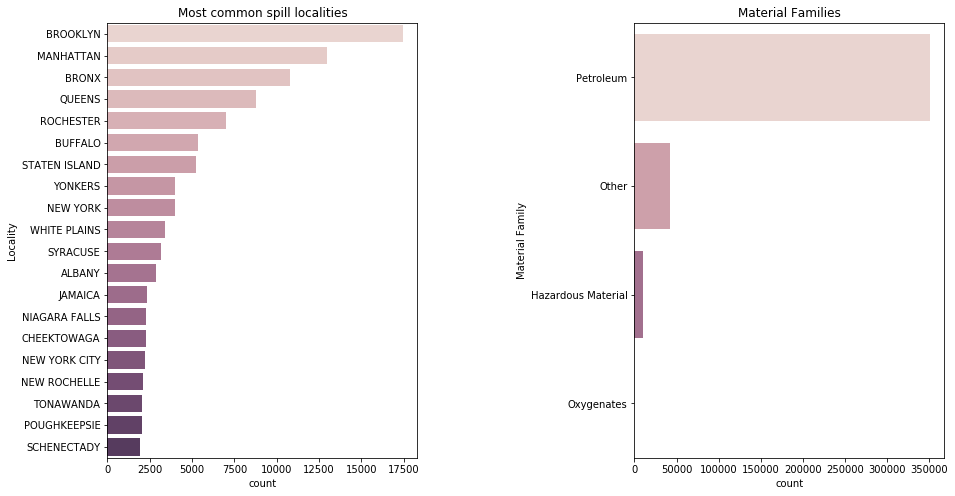

In [64]:
f, axes = plt.subplots(1,2)
f.set_figheight(8)
f.set_figwidth(15)
plt.subplots_adjust(wspace=.7)
axes[0].set_title("Most common spill localities")
sns.countplot(y="Locality", data=NYSspillsRAW_df5, order=top20SpillLocalities.index, palette=p3, ax=axes[0])
axes[1].set_title("Material Families")
sns.countplot(y="Material Family", data=NYSspillsRAW_df5, order=matCat_freq.index, palette=p4, ax=axes[1])

In [ ]:
# source vs cause

In [66]:
# http://www.datasciencemadesimple.com/cross-tab-cross-table-python-pandas/
sourcesVScauses_dfX = pd.crosstab(NYSspillsRAW_df5['Source'], NYSspillsRAW_df5['Contributing Factor'],margins=True)

In [67]:
sourcesVScauses_df = sourcesVScauses_dfX.drop('Missing Code in Old Data - Must be fixed',1).copy()
sourcesVScauses_df

Contributing Factor,Abandoned Drums,Deliberate,Equipment Failure,Housekeeping,Human Error,Other,Storm,Tank Failure,Tank Overfill,Tank Test Failure,Traffic Accident,Unknown,Vandalism,All
Source,,,,,,,,,,,,,,
Airport/Aircraft,0,0,21,1,4,0,0,0,0,0,0,2,0,28
Chemical Bulk Storage Facility,0,3,24,3,6,9,0,0,0,0,1,3,0,49
Commercial Vehicle,72,697,27323,305,3042,2633,15,333,636,26,12978,2261,85,50406
Commercial/Industrial,1251,5918,49789,6019,8256,14188,811,4091,2342,5318,2675,15543,569,116776
Gasoline Station or other PBS Facility,101,715,7340,2123,3638,5025,12,1811,1036,3145,376,5935,66,31323
"Institutional, Educational, Gov., Other",459,1108,11938,1299,2465,5400,64,2494,1199,4700,325,3944,165,35561
"Major Facility (MOSF) > 400,000 gal",5,37,2384,98,655,662,37,122,159,93,28,567,11,4858
"Non Major Facility > 1,100 gal",7,57,877,282,322,370,3,294,169,281,9,406,14,3091
Passenger Vehicle,19,791,3416,214,761,1011,3,257,146,9,4967,473,26,12093


In [68]:
sourcesVScauses_df.shape

(16, 14)

In [69]:
# take out the 'All' row/column
sourcesVScauses_df2 = sourcesVScauses_df.iloc[0:15,0:13].copy()

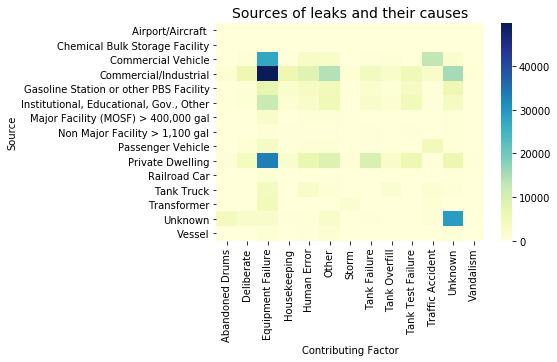

In [190]:
# make a heat map
plt.title('Sources of leaks and their causes', fontsize=14)
sns.heatmap(sourcesVScauses_df2, cmap='YlGnBu')

In [ ]:
# Let's explore the nature of the hazardous liquid spills

In [ ]:
# where do the most liquid spills come from (source)

In [102]:
liquidSpills_df = NYSspillsRAW_df5[NYSspillsRAW_df5['Units'] == 'Gallons'].copy()

In [125]:
hazLiquidSpills_df = liquidSpills_df[(liquidSpills_df['Material Family']=='Petroleum') | (liquidSpills_df['Material Family']=='Hazardous Material')]

In [127]:
volSpilledVSsources_dfX = hazLiquidSpills_df.groupby(['Source','Material Family']).sum()

In [132]:
volSpilledVSsources_dfX2 = volSpilledVSsources_dfX.sort_values('Quantity', ascending=False).copy()

In [133]:
volSpilledVSsources_dfX2

,,Quantity
Source,Material Family,
"Major Facility (MOSF) > 400,000 gal",Petroleum,2.407893e+08
Commercial/Industrial,Petroleum,1.164723e+08
"Institutional, Educational, Gov., Other",Petroleum,8.302705e+06
Unknown,Petroleum,4.793002e+06
Vessel,Petroleum,4.774362e+06
Private Dwelling,Petroleum,2.114981e+06
Commercial Vehicle,Petroleum,2.002598e+06
Commercial/Industrial,Hazardous Material,1.510578e+06
Tank Truck,Petroleum,1.246837e+06


In [139]:
hazLiquidSpills_df.head()

,Street 1,Locality,County,Spill Date,Contributing Factor,Source,Material Name,Material Family,Quantity,Units
Spill Date,,,,,,,,,,
1984-01-01,TOWN WELL SUPPLY,CHESTERTOWN,Warren,1984-01-01,Unknown,Unknown,gasoline,Petroleum,0.0,Gallons
1984-01-01,RT. 40,GRANVILLE,Washington,1984-01-01,Unknown,Unknown,gasoline,Petroleum,0.0,Gallons
1984-01-01,RT. 40,GRANVILLE,Washington,1984-01-01,Unknown,Unknown,#2 fuel oil,Petroleum,0.0,Gallons
1984-01-02,22 MEADOWOOD DRIVE,PERINTON,Monroe,1984-01-02,Unknown,Unknown,#2 fuel oil,Petroleum,10.0,Gallons
1984-01-04,BLUE BARNES ROAD,BURNT HILLS,Saratoga,1984-01-04,Equipment Failure,Private Dwelling,#2 fuel oil,Petroleum,200.0,Gallons


In [144]:
# sources of petroleum, hazardous material
hazLiqSources_df = pd.crosstab(hazLiquidSpills_df['Source'], hazLiquidSpills_df['Material Family'],margins=True)

In [146]:
hazLiqSources_df.shape

(16, 3)

In [147]:
hazLiqSources_df2 = hazLiqSources_df.iloc[0:15,0:2] # drops the 'All' row/column

In [148]:
hazLiqSources_df2

Material Family,Hazardous Material,Petroleum
Source,,
Airport/Aircraft,0,23
Chemical Bulk Storage Facility,21,16
Commercial Vehicle,559,44936
Commercial/Industrial,4080,90819
Gasoline Station or other PBS Facility,93,27786
"Institutional, Educational, Gov., Other",898,28517
"Major Facility (MOSF) > 400,000 gal",158,3559
"Non Major Facility > 1,100 gal",47,2639
Passenger Vehicle,98,10929


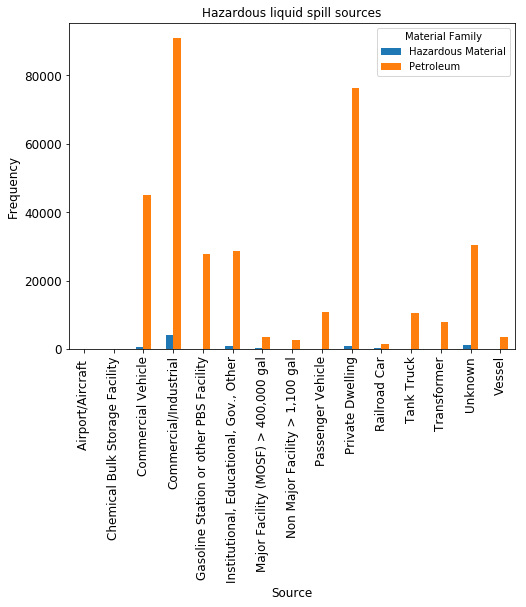

In [189]:
ax = hazLiqSources_df2.plot(kind='bar', title ="Hazardous liquid spill sources", figsize=(8, 6), legend=True, fontsize=12)
ax.set_xlabel("Source", fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)
plt.show()

In [ ]:
# what are the commonest liquids spilled?

In [158]:
commonestliquidsSpilled_df = pd.crosstab(hazLiquidSpills_df['Material Name'],hazLiquidSpills_df['Quantity'].sum(),margins=True)

In [159]:
commonestliquidsSpilled_df.head()

col_0,385232519.7400001,All
Material Name,,
#2 fuel oil,99711,99711
#2 fuel oil (on-site consumption),3,3
#4 fuel oil,3768,3768
#5 fuel oil,4,4
#6 fuel oil,6112,6112


In [160]:
commonestliquidSpills_df2 = hazLiquidSpills_df.groupby(['Material Name']).agg({'Quantity':sum})

In [162]:
commonestliquidSpills_df3 = commonestliquidSpills_df2.sort_values('Quantity', ascending=False).copy()

In [163]:
commonestliquidSpills_df3.head(10)

,Quantity
Material Name,
kerosene,2.019031e+08
diesel,1.065368e+08
#6 fuel oil,3.453341e+07
#2 fuel oil,1.682216e+07
unknown petroleum,7.025165e+06
gasoline,4.678608e+06
jet fuel,4.632472e+06
dielectric fluid,1.461288e+06
asphalt,1.131844e+06


In [167]:
commonestliquidSpills_df4 = commonestliquidSpills_df3.iloc[0:14].copy()

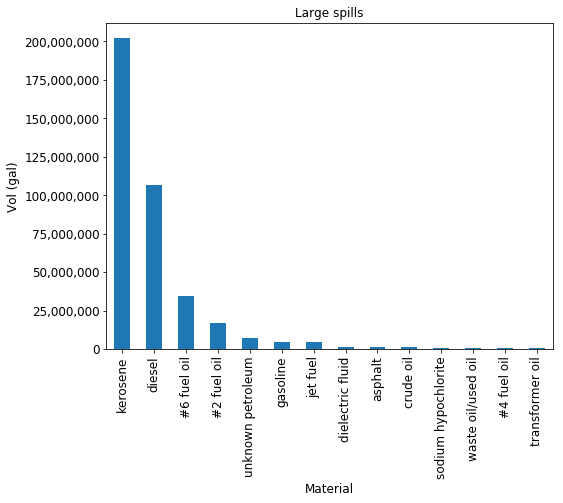

In [188]:
# https://stackoverflow.com/questions/25973581/how-do-i-format-axis-number-format-to-thousands-with-a-comma-in-matplotlib
ax = commonestliquidSpills_df4['Quantity'].plot(kind='bar', title ="Large spills", figsize=(8, 6), legend=False, fontsize=12)
ax.set_xlabel("Material", fontsize=12)

y_labels = ax.get_yticks()
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

ax.set_ylabel("Vol (gal)", fontsize=12)
plt.show()

In [ ]:
# As a former incident investigator in the oil industry, I want to know causes and sources of hydrocarbon spills

In [169]:
matFamVScauses_df = pd.crosstab(hazLiquidSpills_df['Contributing Factor'], hazLiquidSpills_df['Material Family'],margins=True)
matFamVSsources_df = pd.crosstab(hazLiquidSpills_df['Source'], hazLiquidSpills_df['Material Family'],margins=True)

In [170]:
print(matFamVScauses_df.shape)
print(matFamVSsources_df.shape)

(15, 3)
(16, 3)


In [171]:
# drop the 'All' row/column
matFamVScauses_df2 = matFamVScauses_df.iloc[0:14,0:2].copy()
matFamVSsources_df2 = matFamVSsources_df.iloc[0:15,0:2].copy()

In [172]:
matFamVScauses_df3 = matFamVScauses_df2.drop('Missing Code in Old Data - Must be fixed',0).copy()
matFamVScauses_df4 = matFamVScauses_df3.sort_values('Petroleum', ascending=False).copy()
matFamVScauses_df5 = matFamVScauses_df4['Petroleum'].copy()

In [173]:
matFamVSsources_df3 = matFamVSsources_df2.sort_values('Petroleum', ascending=False).copy()
matFamVSsources_df4 = matFamVSsources_df3['Petroleum'].copy()

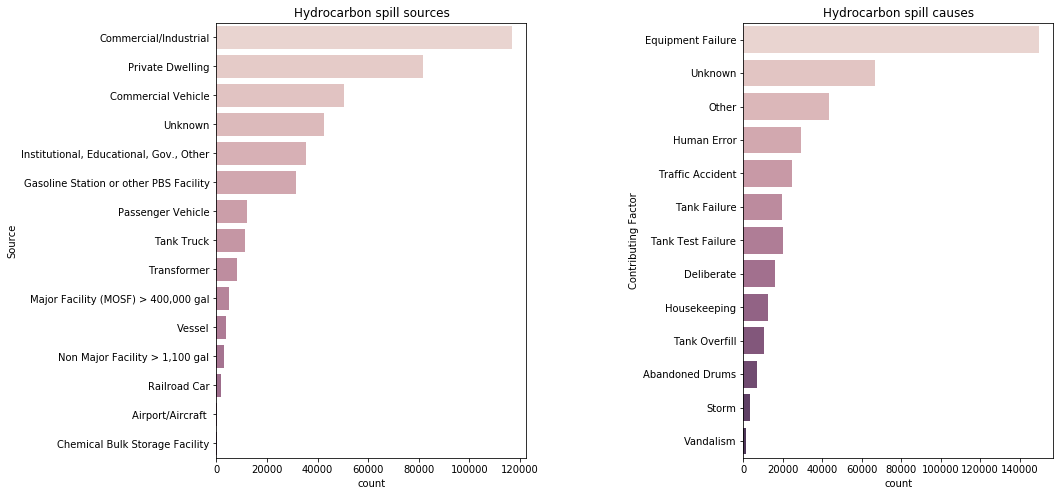

In [174]:
f, axes = plt.subplots(1,2)
f.set_figheight(8)
f.set_figwidth(15)
plt.subplots_adjust(wspace=.7)
axes[0].set_title("Hydrocarbon spill sources")
sns.countplot(y="Contributing Factor", data=NYSspillsRAW_df5, order=matFamVScauses_df5.index, palette=p, ax=axes[1])
axes[1].set_title("Hydrocarbon spill causes")
sns.countplot(y="Source", data=NYSspillsRAW_df5, order=matFamVSsources_df4.index, palette=p3, ax=axes[0])

In [ ]:
# Also of interest (from a public health aspect) are sources/causes of sewage spills

In [180]:
sewageVSsources_dfX = liquidSpills_df.loc[liquidSpills_df['Material Name'] == 'raw sewage']

In [184]:
sewageVSsources_df1 = sewageVSsources_dfX.groupby(['Source']).agg({'Quantity':sum}).sort_values('Quantity', ascending=False).copy()

In [185]:
sewageVSsources_df1

,Quantity
Source,
"Institutional, Educational, Gov., Other",1.693505e+08
"Major Facility (MOSF) > 400,000 gal",1.416299e+08
Commercial/Industrial,1.325297e+08
Unknown,1.724782e+06
"Non Major Facility > 1,100 gal",2.958340e+05
Private Dwelling,3.566900e+04
Commercial Vehicle,2.906500e+04
Tank Truck,9.280000e+03
Vessel,6.050000e+02


In [217]:
sewageVSsources_df2 = sewageVSsources_dfX.groupby(['Source']).count().sort_values('Quantity', ascending=False).copy()

In [219]:
sewageVSsources_df3 = sewageVSsources_df2['Quantity'].copy()
sewageVSsources_df3

Source
Commercial/Industrial                      2126
Institutional, Educational, Gov., Other    1248
Unknown                                     649
Private Dwelling                            562
Major Facility (MOSF) > 400,000 gal         409
Non Major Facility > 1,100 gal              143
Commercial Vehicle                          130
Tank Truck                                   28
Vessel                                       20
Gasoline Station or other PBS Facility       13
Passenger Vehicle                            13
Railroad Car                                  3
Airport/Aircraft                              2
Name: Quantity, dtype: int64

In [239]:
sourceNames1 = list(sewageVSsources_df1.index.values)
sourceNames2 = list(sewageVSsources_df3.index.values)
values1 = list(sewageVSsources_df1.Quantity.values)
values2 = list(sewageVSsources_df3.values)

Text(0.5, 0.98, 'Raw sewage release sources in NY')

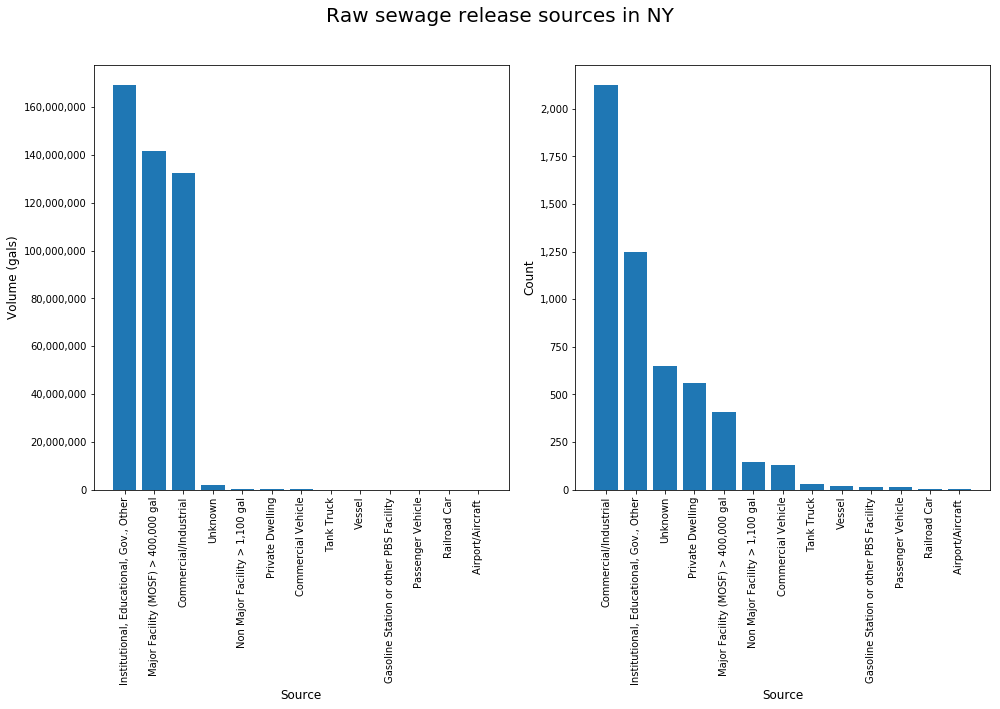

In [321]:
# https://stackoverflow.com/questions/11264521/date-ticks-and-rotation-in-matplotlib
# https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.ticklabel_format.html
# https://stackoverflow.com/questions/7066121/how-to-set-a-single-main-title-above-all-the-subplots-with-pyplot
fig, axs = plt.subplots(1, 2, figsize=(14, 10))

plt.setp( axs[0].xaxis.get_majorticklabels(), rotation=90 )
axs[0].get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
axs[0].bar(sourceNames1, values1)
axs[0].set_xlabel("Source", fontsize=12)
axs[0].set_ylabel("Volume (gals)", fontsize=12)

plt.setp( axs[1].xaxis.get_majorticklabels(), rotation=90 )
axs[1].get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
axs[1].bar(sourceNames2, values2)
axs[1].set_xlabel("Source", fontsize=12)
axs[1].set_ylabel("Count", fontsize=12)

fig.tight_layout()
fig.subplots_adjust(top=0.90)

fig.suptitle('Raw sewage release sources in NY', fontsize=20)

In [ ]:
# where did the big spills come from? Let's look at the two things that get spilled the most: sewage and kerosene

In [ ]:
# big spills - sewage

In [260]:
bigSpills_df1 = liquidSpills_df[['Source','Material Name','Quantity']].copy()

In [261]:
# isolate sewage spills from 
bigSpills_df2 = bigSpills_df1[bigSpills_df1['Material Name']=='raw sewage'].copy()

In [262]:
# list sewage spills in descending order
# https://stackoverflow.com/questions/37787698/how-to-sort-pandas-dataframe-from-one-column
bigSpills_df4 = bigSpills_df2.sort_values('Quantity', ascending=False).copy()
bigSpills_df4.head(10)

,Source,Material Name,Quantity
Spill Date,,,
1997-06-28,"Institutional, Educational, Gov., Other",raw sewage,150000000.0
1999-05-05,"Major Facility (MOSF) > 400,000 gal",raw sewage,103000000.0
2005-11-30,Commercial/Industrial,raw sewage,60000000.0
2001-04-02,Commercial/Industrial,raw sewage,24000000.0
2005-03-28,"Major Facility (MOSF) > 400,000 gal",raw sewage,23000000.0
1995-11-12,"Major Facility (MOSF) > 400,000 gal",raw sewage,10000000.0
2012-10-29,Commercial/Industrial,raw sewage,10000000.0
2012-10-29,Commercial/Industrial,raw sewage,10000000.0
1996-05-31,Commercial/Industrial,raw sewage,7990000.0


In [264]:
# aggregate and sort by source
sewageSpilled_df = bigSpills_df4.groupby(['Source']).agg({'Quantity':sum})
sewageSpilled_df1 = sewageSpilled_df.sort_values('Quantity', ascending=False).copy()
sewageSpilled_df1.head(10)

,Quantity
Source,
"Institutional, Educational, Gov., Other",1.693505e+08
"Major Facility (MOSF) > 400,000 gal",1.416299e+08
Commercial/Industrial,1.325297e+08
Unknown,1.724782e+06
"Non Major Facility > 1,100 gal",2.958340e+05
Private Dwelling,3.566900e+04
Commercial Vehicle,2.906500e+04
Tank Truck,9.280000e+03
Vessel,6.050000e+02


In [ ]:
# kerosene

In [265]:
bigSpills_df3 = bigSpills_df1[bigSpills_df1['Material Name']=='kerosene'].copy()

In [266]:
bigSpills_df5 = bigSpills_df3.sort_values('Quantity', ascending=False).copy()

In [268]:
keroseneSpilled_df = bigSpills_df5.groupby(['Source']).agg({'Quantity':sum})
keroseneSpilled_df1 = keroseneSpilled_df.sort_values('Quantity', ascending=False).copy()
keroseneSpilled_df1.head(10)

,Quantity
Source,
"Major Facility (MOSF) > 400,000 gal",2.004791e+08
Commercial/Industrial,8.668779e+05
Vessel,2.232420e+05
Private Dwelling,2.204405e+05
Tank Truck,3.876400e+04
Gasoline Station or other PBS Facility,2.544664e+04
Commercial Vehicle,1.566260e+04
"Non Major Facility > 1,100 gal",1.488600e+04
"Institutional, Educational, Gov., Other",9.533350e+03


In [274]:
sourceNames3 = list(sewageSpilled_df1.index[0:9].values)
sourceNames4 = list(keroseneSpilled_df1.index[0:9].values)
values3 = list(sewageSpilled_df1.Quantity[0:9].values)
values4 = list(keroseneSpilled_df1.Quantity[0:9].values)

In [314]:
print(sourceNames3)
print(sourceNames4)
print(values3)
print(values4)

['Institutional, Educational, Gov., Other', 'Major Facility (MOSF) > 400,000 gal', 'Commercial/Industrial', 'Unknown', 'Non Major Facility > 1,100 gal', 'Private Dwelling', 'Commercial Vehicle', 'Tank Truck', 'Vessel']
['Major Facility (MOSF) > 400,000 gal', 'Commercial/Industrial', 'Vessel', 'Private Dwelling', 'Tank Truck', 'Gasoline Station or other PBS Facility', 'Commercial Vehicle', 'Non Major Facility > 1,100 gal', 'Institutional, Educational, Gov., Other']
[169350499.0, 141629850.02, 132529689.59, 1724782.0, 295834.0, 35669.0, 29065.0, 9280.0, 605.0]
[200479079.0, 866877.89, 223242.0, 220440.51000000007, 38764.0, 25446.640000000003, 15662.6, 14886.0, 9533.35]


Text(0.5, 0.98, 'Major spill sources in NY')

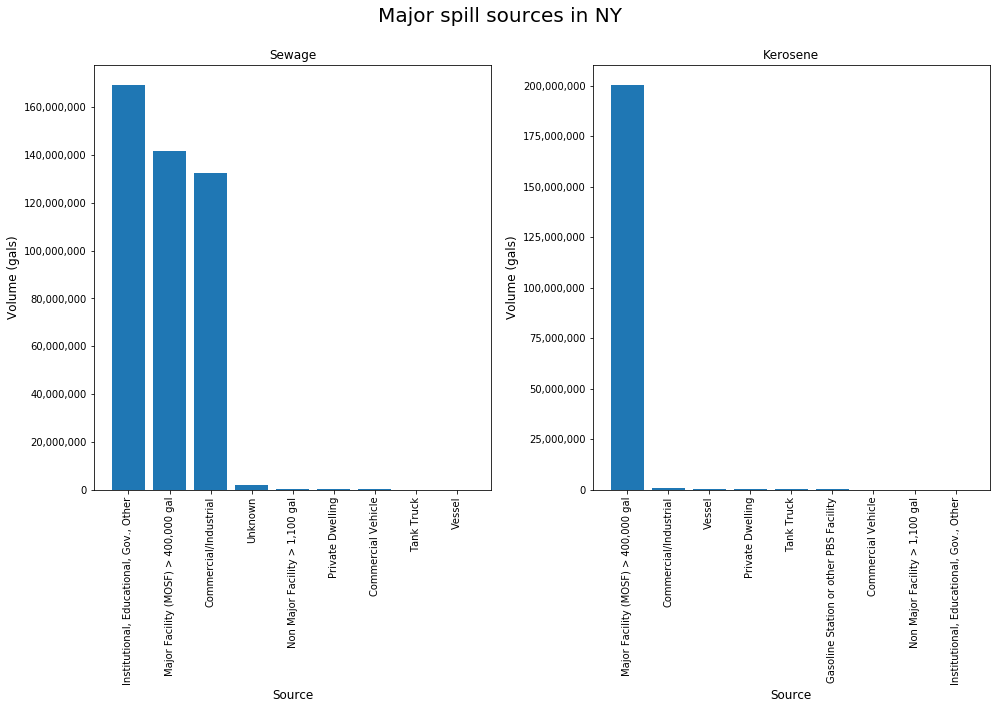

In [320]:
fig, axs = plt.subplots(1, 2, figsize=(14, 10))

plt.setp( axs[0].xaxis.get_majorticklabels(), rotation=90 )
axs[0].get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

axs[0].bar(sourceNames3, values3)
axs[0].set_title("Sewage")
axs[0].set_xlabel("Source", fontsize=12)
axs[0].set_ylabel("Volume (gals)", fontsize=12)

plt.setp( axs[1].xaxis.get_majorticklabels(), rotation=90 )
axs[1].get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

axs[1].bar(sourceNames4, values4)
axs[1].set_title("Kerosene")
axs[1].set_xlabel("Source", fontsize=12)
axs[1].set_ylabel("Volume (gals)", fontsize=12)

fig.tight_layout()
fig.subplots_adjust(top=0.90)

fig.suptitle('Major spill sources in NY', fontsize=20)

In [ ]:
# at what time of day do most industrial spills occur

In [296]:
spillTimes_df = NYSspillsRAW_df5[['Street 1', 'Locality', 'County', 'Spill Date', 'Contributing Factor',
                                'Source', 'Material Name', 'Material Family', 'Quantity', 'Units']]

In [297]:
spillTimes_df["Year"] = spillTimes_df['Spill Date'].dt.year
spillTimes_df["Day"] = spillTimes_df['Spill Date'].dt.day
spillTimes_df["Day_of_week"] = spillTimes_df['Spill Date'].dt.dayofweek
spillTimes_df["Month"] = spillTimes_df['Spill Date'].dt.month

In [298]:
spillTimes_df.head()

,Street 1,Locality,County,Spill Date,Contributing Factor,Source,Material Name,Material Family,Quantity,Units,Year,Day,Day_of_week,Month
Spill Date,,,,,,,,,,,,,,
1984-01-01,TOWN WELL SUPPLY,CHESTERTOWN,Warren,1984-01-01,Unknown,Unknown,gasoline,Petroleum,0.0,Gallons,1984,1,6,1
1984-01-01,RT. 40,GRANVILLE,Washington,1984-01-01,Unknown,Unknown,gasoline,Petroleum,0.0,Gallons,1984,1,6,1
1984-01-01,RT. 40,GRANVILLE,Washington,1984-01-01,Unknown,Unknown,#2 fuel oil,Petroleum,0.0,Gallons,1984,1,6,1
1984-01-02,22 MEADOWOOD DRIVE,PERINTON,Monroe,1984-01-02,Unknown,Unknown,#2 fuel oil,Petroleum,10.0,Gallons,1984,2,0,1
1984-01-04,BLUE BARNES ROAD,BURNT HILLS,Saratoga,1984-01-04,Equipment Failure,Private Dwelling,#2 fuel oil,Petroleum,200.0,Gallons,1984,4,2,1


In [299]:
sewageInstEd_df = spillTimes_df[spillTimes_df['Source'] == 'Institutional, Educational, Gov., Other']
sewageMajFac_df = spillTimes_df[spillTimes_df['Source'] == 'Major Facility (MOSF) > 400,000 gal']

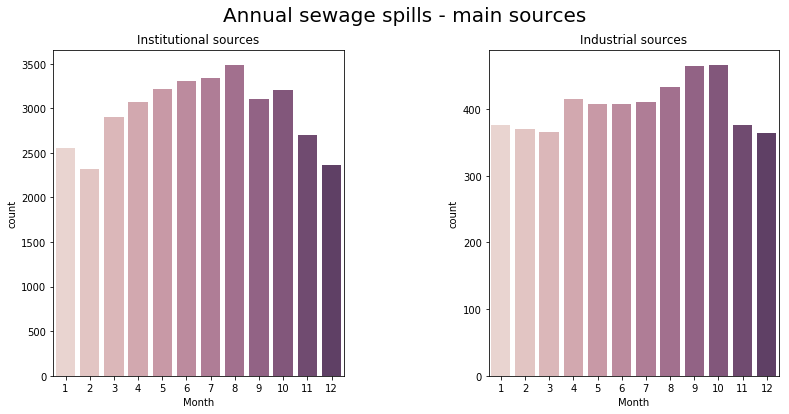

In [303]:
f, axes = plt.subplots(1,2)
f.set_figheight(6)
f.set_figwidth(13)
f.suptitle("Annual sewage spills - main sources", fontsize=20)
plt.subplots_adjust(wspace=.5)
axes[0].set_title("Institutional sources")
sns.countplot(x="Month", data=sewageInstEd_df, palette=p, ax=axes[0])
axes[1].set_title("Industrial sources")
sns.countplot(x="Month", data=sewageMajFac_df, palette=p, ax=axes[1])

In [ ]:
# what regulated chemicals e.g. OSHA highly hazardoussubstances (HHS) were spilled and from where (geopy location + folium)

In [324]:
# https://www.osha.gov/laws-regs/regulations/standardnumber/1910/1910.119AppA
hazardousChems_df = pd.read_csv('OSHA_highly_hazardous_chemicals.csv')

In [325]:
hazardousChems_df.head()

,CHEMICAL name
0,Acetaldehyde
1,Acrolein
2,2-Propenal
3,Acrylyl Chloride
4,Allyl Chloride


In [326]:
hazardousChemsX = list(hazardousChems_df['CHEMICAL name'])

In [327]:
hazardousChems = [chem.lower() for chem in hazardousChemsX]

In [328]:
chemsSpilledX = list(NYSspillsRAW_df5['Material Name'])
chemsSpilled = [chem.lower() for chem in chemsSpilledX]

In [329]:
hazChemsSpilled = [chem for chem in chemsSpilled if chem in hazardousChems]

In [330]:
len(hazChemsSpilled)

1471

In [331]:
hazChemsSpilled[:20]

['hydrogen sulfide',
 'chlorine',
 'nitric acid',
 'nitric acid',
 'hydrogen chloride',
 'hydrogen chloride',
 'formaldehyde',
 'chlorine',
 'hydrogen chloride',
 'hydrogen chloride',
 'hydrogen peroxide',
 'nitric acid',
 'chlorine',
 'nitric acid',
 'chlorine',
 'formaldehyde',
 'hydrogen peroxide',
 'hydrogen peroxide',
 'formaldehyde',
 'hydrogen chloride']

In [332]:
hazChemsSpilledUnique = []
for chem in hazChemsSpilled:
    if chem not in hazChemsSpilledUnique:
        hazChemsSpilledUnique.append(chem)

In [333]:
len(hazChemsSpilledUnique)

39

In [334]:
print(hazChemsSpilledUnique)

['hydrogen sulfide', 'chlorine', 'nitric acid', 'hydrogen chloride', 'formaldehyde', 'hydrogen peroxide', 'methyl bromide', 'hydrogen cyanide', 'ethylene oxide', 'hydrogen bromide', 'methyl chloride', 'bromine', 'oleum', 'hydrogen fluoride', 'methyltrichlorosilane', 'diborane', 'phosphine', 'allyl chloride', 'formalin', 'dimethyldichlorosilane', 'methyl mercaptan', 'methyl isocyanate', 'peracetic acid', 'phosgene', 'hydrochloric acid', 'thionyl chloride', 'chlorine dioxide', 'nitrogen dioxide', 'nitric oxide', 'boron trichloride', 'methyl ethyl ketone peroxide', 'sarin', 'acrylyl chloride', 'methyl vinyl ketone', 'boron trifluoride', 'fluorine', 'acrolein', 'hydrofluoric acid', 'methacryloyloxyethyl isocyanate']


In [335]:
# isolate the HHS releases
# https://cmsdk.com/python/select-rows-from-a-dataframe-based-on-values-in-a-column-in-pandas.html
hazChemSpilled_dfX = spillTimes_df.loc[spillTimes_df['Material Name'].isin(hazChemsSpilledUnique)].dropna()

In [337]:
# and drop the zero entries
hazChemSpilled_df = hazChemSpilled_dfX[hazChemSpilled_dfX.Quantity > 0]

In [338]:
hazChemSpilled_df.head(10)

,Street 1,Locality,County,Spill Date,Contributing Factor,Source,Material Name,Material Family,Quantity,Units,Year,Day,Day_of_week,Month
Spill Date,,,,,,,,,,,,,,
1984-06-15,2301 WESTSIDE DRIVE,CHILI,Monroe,1984-06-15,Unknown,Unknown,chlorine,Hazardous Material,150.0,Pounds,1984,15,4,6
1984-11-18,200 ANDERSON AVE,ROCHESTER,Monroe,1984-11-18,Equipment Failure,Unknown,hydrogen chloride,Hazardous Material,100.0,Gallons,1984,18,6,11
1985-04-02,"NYS THRUWAY, EXIT 47 TOLL",LEROY,Genesee,1985-04-02,Unknown,Unknown,hydrogen chloride,Hazardous Material,1.0,Gallons,1985,2,1,4
1985-04-17,1083 MT READ BLVD,ROCHESTER,Monroe,1985-04-17,Unknown,Unknown,formaldehyde,Hazardous Material,3.0,Gallons,1985,17,2,4
1985-07-08,"ONTARIO STP 2203, LAKE RD",ONTARIO,Wayne,1985-07-08,Unknown,Unknown,hydrogen peroxide,Hazardous Material,25.0,Gallons,1985,8,0,7
1985-08-12,701 JEFFERSON ROAD,HENRIETTA,Monroe,1985-08-12,Unknown,Unknown,nitric acid,Hazardous Material,20.0,Gallons,1985,12,0,8
1985-10-05,3131 S WINTON RD,ROCHESTER,Monroe,1985-10-05,Human Error,Unknown,chlorine,Hazardous Material,25.0,Gallons,1985,5,5,10
1986-03-31,690 & BRIDGE ST,SOLVAY,Onondaga,1986-03-31,Tank Failure,Commercial/Industrial,nitric acid,Hazardous Material,1500.0,Gallons,1986,31,0,3
1986-04-05,UNKNOWN,CHILI,Monroe,1986-04-05,Equipment Failure,"Institutional, Educational, Gov., Other",chlorine,Hazardous Material,100.0,Pounds,1986,5,5,4


In [339]:
hazChemSpilled_df.shape

(947, 14)

In [ ]:
# let's explore where these all are, using geopy...

In [340]:
street = list(hazChemSpilled_df['Street 1'])
locality = list(hazChemSpilled_df['Locality'])
county = list(hazChemSpilled_df['County'])

In [341]:
# make a list of locations for which to obtain coordinates from geopy
locForGeopy = []
for i in range(len(street)):
    inter = street[i] + ', ' + locality[i] + ', ' + county[i] + ', ' + 'New York'
    locForGeopy.append(inter)

In [ ]:
"""
Geopy is prone to timing out. I used a sleep time to space out the requests, with varying degrees of success.
I had to go through the following routine numerous times to fully populate the list. To spare us all the pain,
I have created a csv file of the results

The procedure I used to get the data in the csv file is as follows

1. Create an empty list in which to put the geopy object for each location:
locations=[]

2. Start collecting geopy objects
for i in range(len(locForGeopy)):
    locations.append(nom.geocode(locForGeopy[i]))
    print(locations[i])
    time.sleep(3)
    
3. Upon time out, check the length of locations
j = len(locations)

4. Use len(locations) as the start point for the next collection round:
for i in range(j,len(locForGeopy)):
    locations.append(nom.geocode(locForGeopy[i]))
    print(locations[i])
    time.sleep(3)
    
5. Once the collection stage was completed, I added the geopy locations to the DF...
hazChemSpilled_df['Location'] = locations

6. ..and dropped all the rows that geopy couldn't populate
hazChemSpilled_df2 = hazChemSpilled_df.dropna().copy()

7. I then used the geopy objects in the 'Location' column to get longitude and latitude
locs4LatLon = list(hazChemSpilled_df2.Location)
lat_haz = []
lon_haz = []

for loc in locs4LatLon:
    lat_haz.append(loc.latitude)
    lon_haz.append(loc.longitude)
    
8. and made separate columns for them in the DF
hazChemSpilled_df2['Lat'] = lat_haz
hazChemSpilled_df2['Lon'] = lon_haz

9. Finally, I made my csv file
hazChemSpilled_df2.to_csv('StateOfNY_HazchemSpills_coords.csv')

"""

In [342]:
hazChemSpilled_dfX = pd.read_csv('StateOfNY_HazchemSpills_coords.csv')

In [343]:
hazChemSpilled_dfX.head()

,Spill Date,Street 1,Locality,County,Spill Date.1,Contributing Factor,Source,Material Name,Material Family,Quantity,Units,Year,Day,Day_of_week,Month,Location,Lat,Lon
0,2010-02-25,260 HUDSON RIVER RD,WATERFORD,Saratoga,2010-02-25,Unknown,Commercial/Industrial,methyl chloride,Hazardous Material,1.43,Pounds,2010.0,25.0,3.0,2.0,"260, Hudson River Road, Town of Waterford, Sar...",42.814800,-73.665534
1,1998-04-03,300 WEST GENESEE,SYRACUSE,Onondaga,1998-04-03,Human Error,Unknown,hydrogen chloride,Hazardous Material,1.00,Gallons,1998.0,3.0,4.0,4.0,"300, West Genesee Street, Armory Square, Syrac...",43.052078,-76.155136
2,1997-03-06,11 WEST STREET,BROOKLYN,Kings,1997-03-06,Unknown,Commercial/Industrial,nitric acid,Hazardous Material,11.00,Gallons,1997.0,6.0,3.0,3.0,"11, West Street, Greenpoint, BK, Kings County,...",40.726563,-73.958915
3,1995-04-16,119 CLIFTON STREET,ROCHESTER,Monroe,1995-04-16,Abandoned Drums,Unknown,hydrogen chloride,Hazardous Material,5.00,Gallons,1995.0,16.0,6.0,4.0,"119, Clifton Street, Rochester, Monroe County,...",43.149136,-77.631562
4,2000-09-06,131 APPLEWOOD DRIVE,GREECE,Monroe,2000-09-06,Deliberate,Private Dwelling,hydrogen chloride,Hazardous Material,1.00,Gallons,2000.0,6.0,2.0,9.0,"131, Applewood Drive, Greece, Greece Town, Mon...",43.244482,-77.679154


In [344]:
# find the top 10 most frequently occurring locations
topTenHazSpilllLox_df = hazChemSpilled_dfX['Street 1'].value_counts()[:10].sort_values(ascending=False)

In [345]:
topTenHazSpilllLox_df

260 HUDSON RIVER ROAD      73
SHORE AIRPORT ROAD         19
1000 SHORE AIRPORT ROAD    16
BUFFALO AVENUE             14
4700 BUFFALO AVENUE        11
2400 BUFFALO AVE            9
260 HUDSON RIVER RD         8
2400 BUFFALO AVENUE         7
607 UNION AVENUE            7
BUILDING 27                 7
Name: Street 1, dtype: int64

In [347]:
# find the top 10 most frequently spilled HHS's
topTenHazChemsSpilled_df = hazChemSpilled_dfX['Material Name'].value_counts()[:10].sort_values(ascending=False)

In [348]:
topTenHazChemsSpilled_df

hydrogen chloride    163
chlorine             106
methyl chloride       51
nitrogen dioxide      46
nitric acid           37
hydrochloric acid     32
formaldehyde          26
methyl mercaptan      25
hydrogen peroxide     17
nitric oxide          14
Name: Material Name, dtype: int64

In [ ]:
# lets map these

In [ ]:
# make incomes map
# https://python-graph-gallery.com/313-bubble-map-with-folium/

NYhazSpillMap_v0 = folium.Map(location=[42.996466, -74.473269], zoom_start=8)

# folium marker colors:
markerColor=['lightgreen','green', 'darkgreen', 'lightblue', 'blue', 'darkblue',
             'cadetblue', 'purple', 'darkpurple', 'orange','beige',
             'lightred', 'pink', 'gray', 'black', 'lightgray', 'red', 'darkred', 'white']

# add towns, incomes, coords

chemNames = list(hazChemSpilled_df2['Material Name'].values)
latChem = list(hazChemSpilled_df2.Lat.values)
lonChem = list(hazChemSpilled_df2.Lon.values)

for i in range(0,len(chemNames)):
    folium.Circle(
       location = [latChem[i], lonChem[i]],
       popup = chemNames[i],
       radius = 50,
       color = markerColor[7],
       fill = True,
       fill_color = markerColor[7]
    ).add_to(NYhazSpillMap_v0)
    
# Save it as html
NYhazSpillMap_v0.save('NY_HazChemSpills.html')

In [349]:
# lets plot petroleum product spills vs time: needs consistent units (gallons), non-zero entries, dates in ascending order

In [350]:
petroleumSpills_dfX = liquidSpills_df[liquidSpills_df.Quantity > 0].copy()

In [351]:
len(petroleumSpills_dfX)

218124

In [ ]:
# put in date order

In [352]:
petroleumSpills_df = petroleumSpills_dfX.sort_index().copy()

In [ ]:
# set a date range

In [353]:
# https://chrisalbon.com/machine_learning/preprocessing_dates_and_times/select_date_and_time_ranges/
petroleumSpills_df2 = petroleumSpills_df[petroleumSpills_df['Spill Date'] > '1984-01-01']

In [354]:
petroleumSpills_ts = pd.Series(petroleumSpills_df2.Quantity)

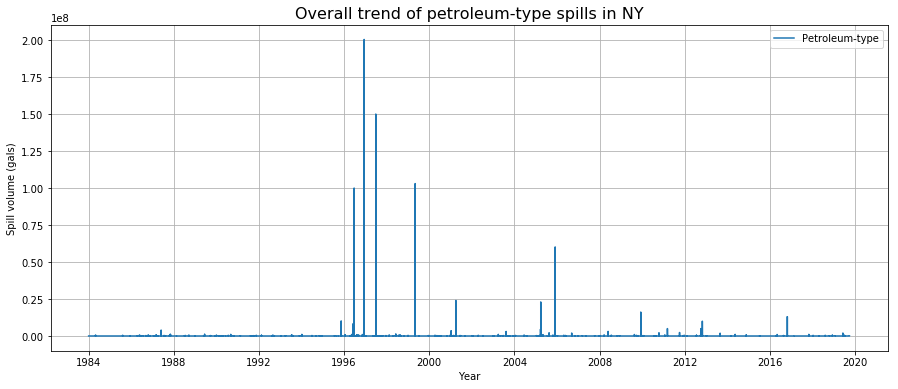

In [359]:
plt.figure(figsize = (15,6))

plt.title('Overall trend of petroleum-type spills in NY', fontsize=16)
plt.ylabel('Spill volume (gals)')
plt.xlabel('Year')
plt.plot(petroleumSpills_ts, label='Petroleum-type')
plt.grid(True)
plt.legend()